# <center>Day 3: matching models with imperfectly transferable utility</center>
### <center>Alfred Galichon (NYU)</center>
## <center>'math+econ+code' masterclass on equilibrium transport and matching models in economics</center>
<center>© 2020 by Alfred Galichon.  Support from  NSF DMS-1716489 and ERC CoG-866274 EQUIPRICE grants is acknowledged.</center>

#### <center>with Python code</center>

**If you reuse code from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass on equilibrium transport and matching models in economics, June 2020. https://github.com/math-econ-code/mec_equil


# References

* Alfred Galichon, Scott Kominers, and Simon Weber (2019). "Costly Concessions: An Empirical Framework for Matching with Imperfectly Transferable Utility." *Journal of Political Economy* 127, no. 6, pp. 2875-2925.

# Matching with nonlinear taxes

## Generating the data

We will generate the same type of worker/firm data as yesterday.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

np.random.seed(777)
d = 8
nbx = 50
nby = 30

rg = .8
rs = .6
r  = .7

n_x = np.ones(nbx)
m_y = np.ones(nby)
ξ_x_k = np.random.rand(nbx,d)
ζ_y_k = np.random.rand(nby,d)

α_x_y = np.zeros((nbx,nby))
γ_x_y = np.zeros((nbx,nby))
for x in range(nbx):
    for y in range(nby):
        α_x_y[x,y] = -  np.linalg.norm(ξ_x_k[x,6:7]-ζ_y_k[y,6:7])-5
        γ_x_y[x,y] = 10+5*(np.sum( (ξ_x_k[x,0:3]*ζ_y_k[y,0:3])**rg )**(r/rg)+(  np.sum(  ξ_x_k[x,3:6]*ζ_y_k[y,3:6] )**rs )**(r/rs))**r
        
Φ_x_y = α_x_y + γ_x_y

## Tax schedule

In 2020, the federal tax schedule for a single taxpayer was as follows: 

|MARGINAL RATE | LOWER BRACKET | UPPER BRACKET  | TAX OWED  |
| :----- | :----- | :----- | :------------------------------------------------------------- |
| 10\% | \$0  | \$9,700    | 10\% of taxable income |
| 12\% | \$9,701 | \$39,475 | \$970 plus 12\% of the excess over \\$9,700 |
| 22\% | \$39,476 | \$84,200 | \$4,543 plus 22\% of the excess over \\$39,475 |
| 24\% | \$84,201 | \$160,725 | \$14,382.50 plus 24\% of the excess over \\$84,200 |
| 32\% | \$160,726 | \$204,100 | \$32,748.50 plus 32\% of the excess over \\$160,725 |
| 35\% | \$204,101 | \$510,300 | \$46,638.50 plus 35\% of the excess over \\$204,100 |
| 37\% | \$510,300 | - | \$153,798.50 plus 37\% of the excess over \\$510,300 |

(Source: https://www.investopedia.com/terms/t/taxbracket.asp)

Let $g$ be the gross wage, and $n$ be the net wage, we have that the net wage is a piecewise linear, increasing and concave function of the gross wage, whose slopes are $1-\tau_k$, so it expresses as $$ n = \min_k \{N_k+(1-\tau_k) g\},$$
where we have added $k=0,W_0=1,\tau_0=0$ to express that there is no tax on negative wages.

We encode this as:


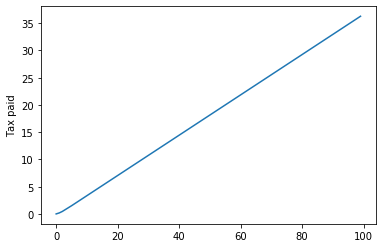

In [2]:
lower_bracket = np.array([0, 9.701, 39.476, 84.201, 160.726, 204.101, 510.300])/100
marginal_tax =  np.array([.1,.12,   .22,    .24,    .32,     .35,     .37    ])
tax_on_previous_brackets = np.zeros(lower_bracket.size)
for i in range(1,lower_bracket.size):
    tax_on_previous_brackets[i] = tax_on_previous_brackets[i-1] + marginal_tax[i-1]*(lower_bracket[i]-lower_bracket[i-1])
    
N_k = np.append(0,marginal_tax*lower_bracket - tax_on_previous_brackets ) 
τ_k = np.append(0,marginal_tax)
nbk =N_k.size

TaxPaid = np.vectorize(lambda g : max(g*τ_k -N_k))
NetFromGross = np.vectorize(lambda g : min(N_k+g*(1-τ_k)))

import matplotlib.pyplot as plt
gs = np.arange(0,100,1)
ts = TaxPaid(gs)
plt.plot(gs,ts)
plt.ylabel('Tax paid')
plt.show()

## The class `GKW_model`
### Distance function
Note that $n_{xy} \leq \min_k \{N_k+(1-\tau_k) g_{xy}\}$ is equivalent to $$ \frac{- N_k - (1-\tau_k) g_{xy} + n_{xy}} {2 - \tau_k} \leq 0~\forall k.$$
As $n_{xy}=U_{xy}-\alpha_{xy}$ and $g_{xy} = \gamma_{xy} -V_{xy}$, this is equivalent to $$ \frac{ (U_{xy} - \alpha_{xy} ) + (1-\tau_k) ( V_{xy} - \gamma_{xy}) -N_k } {2 - \tau_k} \leq 0~\forall k, $$
therefore, we get
$$ D_{xy}(U,V) = \max_k \left\{ \frac{ (U - \alpha_{xy} ) + (1-\tau_k) ( V - \gamma_{xy}) -N_k } {2 - \tau_k} \right\} $$
or,  setting<br>
$\lambda_k = 1 /  (2 - \tau_k)$ and<br>
$\nu_k = (1 - \tau_k) /  (2 - \tau_k)$ and<br>
$\Phi^k_{xy} = \lambda_k (\alpha_{xy}+N_k) + \nu_k \gamma_{xy}$<br>
$$ D_{xy}(U,V) = \max_k \left\{ \lambda_k U + \nu_k V -  \Phi^k_{xy} \right\} $$
### Matching function
One has $$M_{xy}(\mu_{x0},\mu_{0y})=\exp(-D_{xy}(-\log \mu_{x0},-\log \mu_{0y}))=\min_k \left\{ \mu_{x0}^{\lambda_k}  \mu_{0y}^ {\nu_k} e^{ \Phi^k_{xy}} \right\}  $$

In [3]:
λ_k = 1 / (2-τ_k)
ν_k = (1-τ_k) / (2-τ_k)
Φ_k_x_y = np.zeros((nbk,nbx,nby))
for k in range(nbk):
    for x in range(nbx):
        for y in range(nby):
            Φ_k_x_y[k,x,y] = λ_k[k]*(α_x_y[x,y]+N_k[k])+ν_k[k] * γ_x_y[x,y]

class GKW_model:    
    def __init__(self):
        self.n_x = n_x
        self.m_y = m_y
        self.nbx = n_x.size
        self.nby = m_y.size
        self.eq_μ_x0 = np.array([])
        self.eq_μ_0y = np.array([])
        self.eq_μ_x_y = np.array([])
        self.eq_deltamarg_x = np.array([])
        self.eq_deltamarg_y = np.array([])
        self.eq_deltainvmarg_x = np.array([])
        self.eq_deltainvmarg_y = np.array([])
        self.comp_code = -1
        self.comp_nbsteps = -1
        self.comp_time = -1.0
                

    def Mxy(self,x,y,μx0,μ0y):
        return(np.min(μx0**λ_k * μ0y**ν_k * np.exp(Φ_k_x_y[:,x,y]) ))
        
    def M_x_y(self,μ_x0,μ_0y):
        μ_x_y = np.zeros((self.nbx,self.nby))
        for x in range(self.nbx):
            for y in range(self.nby):
                μ_x_y[x,y] = self.Mxy(x,y,μ_x0[x],μ_0y[y])
        return(μ_x_y)

#############
mkt = GKW_model()
μ_x0 = np.ones(nbx)
μ_0y = np.ones(nby)

mkt.M_x_y(μ_x0,μ_0y)[0:min(nbx,5),0:min(nby,5)]

array([[39.45899939, 19.58072703, 27.95071734, 28.8266575 , 24.50328215],
       [29.45957833, 12.36433326, 16.70880183, 17.3034927 , 14.34040148],
       [19.84066181, 15.91718516, 18.58255001, 32.94379772, 30.50690878],
       [35.88931574, 45.28941904, 33.83492863, 72.50573429, 57.01083497],
       [48.90182463, 28.92587309, 38.50755154, 45.21330023, 39.75223127]])

Next, we compute the mappings<br>
$\mu_{x0} \to \mu_{x0}+\sum_y M_{xy}(\mu_{x0},\mu_{0y})$ and<br>
$\mu_{0y} \to \mu_{0y}+\sum_x M_{xy}(\mu_{x0},\mu_{0y}).$ 

In [4]:
def marginx(self,x,μx0,μ_0y):
    nx = μx0
    for y in range(nby):
        nx +=  self.Mxy(x,y,μx0,μ_0y[y])
    return(nx)
                                             
def marginy(self,y,μ_x0,μ0y):
    my = μ0y
    for x in range(nbx):
        my += self.Mxy(x,y,μ_x0[x],μ0y)
    return(my)


GKW_model.marginx = marginx
GKW_model.marginy = marginy

def margin_x(self,μ_x0,μ_0y):
    μ_x_y = self.M_x_y(μ_x0,μ_0y)
    return(μ_x0+np.sum(μ_x_y,axis = 1))

def margin_y(self,μ_x0,μ_0y):
    μ_x_y = self.M_x_y(μ_x0,μ_0y)
    return(μ_0y+np.sum(μ_x_y,axis = 0))

GKW_model.margin_x = margin_x
GKW_model.margin_y = margin_y

#############
mkt.marginx(0,μ_x0[0],μ_0y) #[0:min(nbx,5)]

941.356380561038

Now we solve in $\mu_{x0}$ the equation<br>
$\mu_{x0}+\sum_y M_{xy}(\mu_{x0},\mu_{0y})=n_x,$<br>
and in $\mu_{0y}$ the equation<br>
$\mu_{0y}+\sum_x M_{xy}(\mu_{x0},\mu_{0y})=m_y.$


In [5]:
import scipy.optimize as opt

def invmarginx(self,x,μ_0y):    
    newμx0 = opt.brentq(lambda theμx0 : self.marginx(x,theμx0,μ_0y)-self.n_x[x],0,self.n_x[x])
    return(newμx0)

def invmarginy(self,y,μ_x0):    
    newμ0y = opt.brentq(lambda theμ0y : self.marginy(y,μ_x0,theμ0y)-self.m_y[y],0,self.m_y[y])
    return(newμ0y )

GKW_model.invmarginx = invmarginx
GKW_model.invmarginy = invmarginy

#############
print(mkt.invmarginx(0,μ_0y)) #[0:min(nbx,5)])
print(mkt.invmarginy(0,μ_x0)) #[0:min(nby,5)])

1.4240432990043214e-05
6.449459191590883e-09


In [6]:
from time import time

def solveIPFP(self, maxit = 1000,maxvaltol=1e-5,maxsteptol=1e-9,output=0):
    start_time = time()
    code = 0
    deltainvmarg_x = np.zeros(self.nbx)
    deltainvmarg_y = np.zeros(self.nby)
    μ_x0 = np.copy(self.n_x)
    μ_0y = np.zeros(self.nby)
    for i in range(maxit):
        for y in range(self.nby):
            newμ0y = self.invmarginy(y,μ_x0)
            deltainvmarg_y[y] = newμ0y - μ_0y[y]
            μ_0y[y] = newμ0y
        for x in range(self.nbx):
            newμx0 = self.invmarginx(x,μ_0y)
            deltainvmarg_x[x] = newμx0 - μ_x0[x]
            μ_x0[x] = newμx0
        
        deltamarg_x = self.margin_x(μ_x0,μ_0y) - n_x
        deltamarg_y = self.margin_y(μ_x0,μ_0y) - m_y
        #print(deltainvmarg_x)
        #print(deltainvmarg_y)
        #print(np.append(deltainvmarg_x,deltainvmarg_y))
        steptol = np.max(np.abs( np.append(deltainvmarg_x,deltainvmarg_y) ) ) 
        valtol = np.max(np.abs(np.append(deltamarg_x,deltamarg_y)) )
        
        if output > 1 :
            print("μ_x0=",μ_x0)
        if valtol < maxvaltol :
            code = 0
            break
        if steptol < maxsteptol :
            code = 1
            break
        code = 2
    comp_time = time() - start_time
    if output > 0 :
        print( 'IPFP converged in', i, 'iterations and ',comp_time,' seconds.')
        #print('Value of μ_x0=",μ_x0)
        print('Max absolute margin discrepancy=', valtol)            
        print('Max absolute update discrepancy =',steptol)
        print('Code =',code)

    self.eq_μ_x0 = μ_x0
    self.eq_μ_0y = μ_0y
    self.eq_μ_x_y = self.M_x_y(μ_x0,μ_0y)
    self.eq_deltamarg_x = deltamarg_x
    self.eq_deltamarg_y = deltamarg_y
    self.eq_deltainvmarg_x = deltainvmarg_x
    self.eq_deltainvmarg_y = deltainvmarg_y
    self.comp_code = code
    self.comp_nbsteps = i
    self.comp_time = comp_time
    return code

    
GKW_model.solveIPFP = solveIPFP
#############
res=mkt.solveIPFP(output=1,maxvaltol=1e-6,maxsteptol=1e-9)  

IPFP converged in 19 iterations and  10.74329924583435  seconds.
Max absolute margin discrepancy= 9.311990810667581e-07
Max absolute update discrepancy = 2.7887852765973165e-07
Code = 0


## Recovering the wages

Recall that we had<br>
$n_{xy}=U_{xy}-\alpha_{xy}$ and $w_{xy} = \gamma_{xy} -V_{xy}$,<br>
and<br>
$U_{xy} = \log \frac {\mu_{xy}} {\mu_{x0}} $ and $V_{xy} = \log \frac {\mu_{xy}} {\mu_{0y}},$<br>
so as a result, we can compute:

In [7]:
nw_x_y = np.log(mkt.eq_μ_x_y / np.repeat(mkt.eq_μ_x0.reshape(-1,1),nby,axis=1) ) - α_x_y
gw_x_y = γ_x_y - np.log(mkt.eq_μ_x_y / np.repeat(mkt.eq_μ_0y.reshape(1,-1),nbx,axis=0) )

In [8]:
nw_x = np.sum(nw_x_y * mkt.eq_μ_x_y,axis = 1) / n_x
gw_x = np.sum(gw_x_y * mkt.eq_μ_x_y,axis = 1) / n_x
print('New wages:')
print(nw_x)
print('Gross wages:')
print(gw_x)

New wages:
[1.30385757 0.8935055  1.10284918 2.04620117 1.75178446 1.73521571
 1.48968658 1.37191615 2.06500547 1.52605521 0.76707772 1.81318585
 2.30519593 2.22903284 1.14984461 2.09419898 1.1192523  1.7028357
 1.96691546 1.39262044 1.46455772 0.55568796 1.28304339 1.290824
 1.7754926  1.57292504 0.88985516 2.37878593 0.45871257 1.55522205
 1.11066551 1.7484393  0.52394862 0.49697816 0.85967415 1.17476213
 1.35904467 1.29928919 2.04306736 1.51228265 1.49612857 1.53383193
 2.15068702 1.37190312 1.64722548 2.48953741 1.05462905 2.21522184
 0.80869984 1.24276472]
Gross wages:
[1.78593497 1.20074426 1.48886591 2.87182579 2.44261692 2.41372419
 2.05275854 1.8806596  2.89865695 2.1131941  1.01282072 2.53255592
 3.25536533 3.14186617 1.55827555 2.94915694 1.51846839 2.36989825
 2.76454771 1.91620008 2.02248659 0.72306444 1.75281883 1.76344577
 2.47761834 2.17851614 1.18232484 3.364415   0.58675593 2.1524392
 1.50923563 2.43266909 0.67013796 0.63383778 1.14035533 1.59421399
 1.86219225 1.7769